# Loan Status Prediction


## Introduction


In this project, I perform data analysis and predictive modelling on Lending Club's loan dataset for the year 2015 in order to understand how different set of features help to indentify customer loan status.   

## Lending Club Data

Lending Club is one of the America's largest lending companies that allows borrowers
to apply and obtain personal loans, auto refinancing, business loans, and elective medical procedures.
Additionally, they make some of their data publically available https://www.lendingclub.com/info/download-data.action.  


![title](https://getbackonfeet.com/wp-content/uploads/2018/10/000-2-1.png)

## ETL Pipline

1. **Data Cleaning**:

    * Drop irrelevant features
    * Clean mixed type features

2. **Exploratory Data Analysis**
    * Visualize different sets of features 
    * Another round of cleaning and featurer extraction
    

3. **Machine Learning** 
    * Feature Normalization
    * Train Test Split
    * ML Prediction
    


### Import Libraries

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

#plotly
from plotly.plotly import iplot
import plotly.graph_objs as go

#my functions
#this functions relocated in order to make
#the report look less bulcky
from src.utility import CleanData, ColorList
from src.plotting import CPlot,plotLoanStat1, plotLoanStat2, plotLoanStat3
from src.ml_models import *

#import ml stuff
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

#suppress warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

### Import Data

We import data by subsetting columns that are relevant and useful in data exploration. Raw data contains nearly 145 features. Some of these features are duplicates, some others are irrelevant( such as id,member_id,url etc.). By eliminating unnecessary features we reduce memory usage and speed up performance. 


In [2]:
keep_cols = ["loan_status","loan_amnt", "term","int_rate","installment","grade",
             "sub_grade","purpose","emp_length","home_ownership","annual_inc",
             "verification_status","issue_d","dti","earliest_cr_line","open_acc",
             "revol_bal","revol_util","total_acc"]
#"zip_code","addr_state"
df_orig = pd.read_csv("data/loan.csv", usecols=keep_cols,skipfooter=4,skiprows=1)#,low_memory=False)

In [3]:
df = df_orig
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 19 columns):
loan_amnt              421095 non-null int64
term                   421095 non-null object
int_rate               421095 non-null object
installment            421095 non-null float64
grade                  421095 non-null object
sub_grade              421095 non-null object
emp_length             397278 non-null object
home_ownership         421095 non-null object
annual_inc             421095 non-null float64
verification_status    421095 non-null object
issue_d                421095 non-null object
loan_status            421095 non-null object
purpose                421095 non-null object
dti                    421093 non-null float64
earliest_cr_line       421095 non-null object
open_acc               421095 non-null int64
revol_bal              421095 non-null int64
revol_util             420933 non-null object
total_acc              421095 non-null int64
dtypes: float64(

Only 19 features are choosen to process further. Feature names are self explanatory. Data info show some numeric or integer data types and some categorical data types(object). Let's take a closer look at a few rows.

In [4]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc
0,24700,36 months,11.99%,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,small_business,16.06,Dec-1999,22,21470,19.2%,38
1,17925,60 months,17.27%,448.09,D,D3,10+ years,OWN,39000.0,Source Verified,Dec-2015,Current,debt_consolidation,27.78,Sep-2002,10,19614,76%,21
2,9000,36 months,8.49%,284.07,B,B1,8 years,MORTGAGE,47000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,8.43,Nov-2000,12,9747,26.7%,22
3,11550,60 months,16.59%,284.51,D,D2,5 years,RENT,38000.0,Not Verified,Dec-2015,Charged Off,credit_card,21.07,Jan-2011,9,7179,39.7%,12
4,12000,60 months,9.80%,253.79,B,B3,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,23.84,Nov-2003,18,9786,13.4%,37


As shown, some features have mixed data type such as number mixed with string that needs cleaning. In addition,
date_time features can be used to extract a new more meaningfull feature. For instance, by subtracting 'earliest credit line' from 'issue date' we obtain 'credit age' that might have more impact on prediction.

* Remove '%' from 'int_rate', 'revol_util' 
* Replace all 'n/a' with np.nan
* Extract numeric part of employment length
* Save name of the loan issued month
* Get credita agae from issue data and earliest credit line
* Again drop some unnecessary columns

###  Feature Cleaning

Here, I call a function that performs data cleaning that is located in 'src/utility.py' file. 


In [5]:
df = CleanData(df)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,issue_month,cred_age
0,24700,36 months,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,Fully Paid,small_business,16.06,22,21470,19.2,38,Dec,16.0
1,17925,60 months,17.27,448.09,D,D3,10,OWN,39000.0,Source Verified,Current,debt_consolidation,27.78,10,19614,76.0,21,Dec,13.0
2,9000,36 months,8.49,284.07,B,B1,8,MORTGAGE,47000.0,Not Verified,Fully Paid,debt_consolidation,8.43,12,9747,26.7,22,Dec,15.0
3,11550,60 months,16.59,284.51,D,D2,5,RENT,38000.0,Not Verified,Charged Off,credit_card,21.07,9,7179,39.7,12,Dec,5.0
4,12000,60 months,9.80,253.79,B,B3,10,MORTGAGE,65000.0,Not Verified,Fully Paid,debt_consolidation,23.84,18,9786,13.4,37,Dec,12.0


Cleaning function did the job by extracting numeric part from mixed data types. Also, we have a new feature that is 'credit age' measured in years. Next we point attantion to a target feature.

### The Target Feature : Loan Status

In [6]:
# simplify target feature
df.loan_status.value_counts()

Fully Paid            296634
Charged Off            74762
Current                46461
Late (31-120 days)      1819
In Grace Period          980
Late (16-30 days)        434
Default                    5
Name: loan_status, dtype: int64

Target feature 'loan_status' is composed of 7 factors. For simplicity, we reduce it down to two 'Good' and 'Bad' loans. We consider 'Fully Paid' and 'Current' as good loans, while the rest as bad loans. Here, I make a new function to achieve above transformation.

In [7]:
good_loans = ['Fully Paid', 'Current']

def ChangeStatus(status):
    if status in good_loans:
        return 'Good Loan'
    else:
        return 'Bad Loan'
tmp = df['loan_status'].apply(ChangeStatus)
df.loan_status = tmp

In [8]:
df.loan_status.value_counts()

Good Loan    343095
Bad Loan      78000
Name: loan_status, dtype: int64

In [9]:
print('Good Loans Fraction =',round(df.loan_status.value_counts()[0]/df.shape[0],2))
print('Bad Loans Fraction =',round(df.loan_status.value_counts()[1]/df.shape[0],2))

Good Loans Fraction = 0.81
Bad Loans Fraction = 0.19


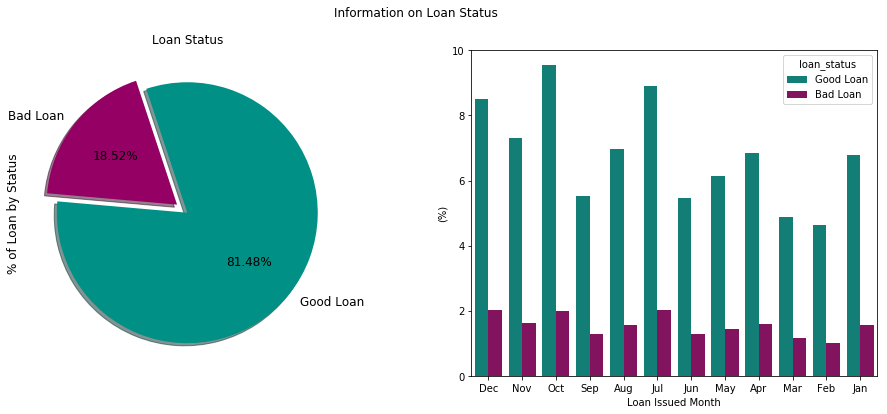

In [10]:
plotLoanStat1(df,colors = ColorList([11,12]))

* Based on fraction of 'Good' and 'Bad' loans, we do have data imbalance problem that must be addressed before applying predictive modelling.
* Percentage of issued loans seem to increase slightly as time passes. Percentage of Good Loans granted every month is nearly 4 times more than Bad Loans.

### Feature Statistics

It is always important to check for extreme cases. For instance, checking min and max values of features might help spot outliers. Pandas have a convinient function 'describe' to fullfill this task.

In [11]:
#statistics of numeric features
df.describe().iloc[[1,2,3,7],:].round(1)

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,cred_age
mean,15240.3,12.6,441.8,5.8,76965.6,19.1,11.9,17685.5,53.8,25.5,16.8
std,8571.3,4.3,244.8,3.8,73950.0,8.9,5.6,24195.0,23.9,12.1,7.6
min,1000.0,5.3,14.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,3.0
max,35000.0,29.0,1445.5,10.0,9500000.0,999.0,90.0,2904836.0,193.0,169.0,71.0


* Max loan amount is 35K, while min loan amount is as low as 1000 dollars. 
* Credit term is either 36 or 60 month, so it is better to keep it as categorical feature.
* Interest rate range seems reasonable (5% - 29%), installments and employement length look fine 
* Max annual income looks too high, let's take closer look!

In [11]:
df[df.annual_inc == 9500000]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,issue_month,cred_age
231029,24000,60 months,7.89,485.38,A,A5,10,MORTGAGE,9500000.0,Source Verified,Bad Loan,credit_card,0.12,12,16854,22.0,31,Jul,33.0


This is indeed interesting case, where customer's loan status was marked as bad with almost 1000K annual income, excellent credit history, and he wanted 24K for 60 month term. Probably, he forgot to make payment on time. This is way higher than national average, and can be considered an outlier.  

In [12]:
#drop_indx = df[df.annual_inc == 9500000].index[0]
#df.drop(drop_indx, inplace=True) # keep it

### Loan Purpose

In [12]:
df.purpose.value_counts()

debt_consolidation    250020
credit_card           102025
home_improvement       25293
other                  19204
major_purchase          7449
medical                 3938
car                     3466
small_business          3364
moving                  2420
vacation                2249
house                   1438
renewable_energy         224
wedding                    4
educational                1
Name: purpose, dtype: int64

Loan is given for variety of different purposes as listed above. Most common cases are debt consolidation, credit card, and home improvement. Now, let's take a look at how amount of loan varies among different loan purposes by loan status using beautiful figure tailored with 'plotly'.

In [14]:
ave_good_loan_by_purpose = df[df.loan_status == 'Good Loan'].groupby('purpose').loan_amnt.mean().astype(int)
ave_bad_loan_by_purpose = df[df.loan_status == 'Bad Loan'].groupby('purpose').loan_amnt.mean().astype(int)

good_bars = go.Bar(
    x = list(ave_good_loan_by_purpose.index),
    y = list(ave_good_loan_by_purpose.values),
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)

bad_bars = go.Bar(
    x = list(ave_bad_loan_by_purpose.index),
    y = list(ave_bad_loan_by_purpose.values),
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219,64,82,0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

data = [good_bars, bad_bars]

layout = go.Layout(
    title='Average Amount of Loan given for Different Purposes Classified by Loan Status',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='Average Loan Amount',
    ),
    paper_bgcolor='rgba(250,200,200,0.3)',
    plot_bgcolor='rgba(250,200,200,0.3)',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig)


Plotly images may not be visible in a github repo. Thus, I also attached locally saved static image.

**Load Static Image**

![title](./newplot1.png)

For most of the loan purposes, red bars are slightly taller than the green. Only money lended for educational or wedding purposes stayed completely clean, meaning no missed payments, no charged offs etc. This suggests that 'loan purpose' feature may be a good candidate for our binary classification problem since it is able to catch some difference between good and bad loans. 

### Feature Correlations

Correlations between features helps to solve collinearity problem. Highly correlated features tend to
negativaly affect the prediction performance by introducing bias towards that specific feature. Thus, in practice, among highy correlated features we keep one, and remove the rest. Here, I use function built on top of matplotlib
('src/plotting.py') to illustrate feature correlation.

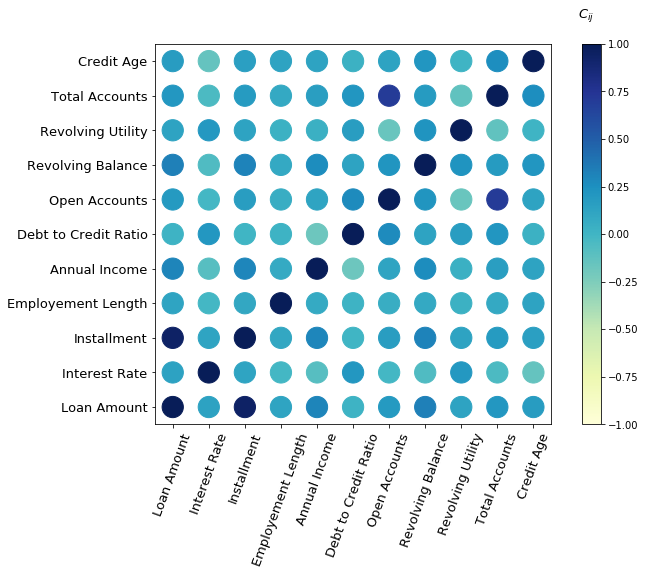

In [14]:
cor = df.corr()
corr_names = ['Loan Amount', 'Interest Rate', 'Installment', 'Employement Length',
              'Annual Income', 'Debt to Credit Ratio', 'Open Accounts', 'Revolving Balance',
              'Revolving Utility', 'Total Accounts','Credit Age']

cmap = "YlGnBu"
plt.figure(figsize=(9,7))
CPlot(corr_mat = cor.values, axis_labs = corr_names,cmap = cmap,
      pad = 0.05,rad = 41*len(cor), xlab = '',ylab = '',fs = 13,
      xtick_lab_rot = 70)

'loan_amnt' and 'installment' are highly correlated. Therefore, we can drop the 'installments'.

In [15]:
df.drop(columns="installment",inplace = True)

## Interest Rate

Interest rate is another interesting aspect of loan to look at. Here, I sort 'grade' and 'sub_grade'
in alphabetic order and check how interest rate varies across different grades. 

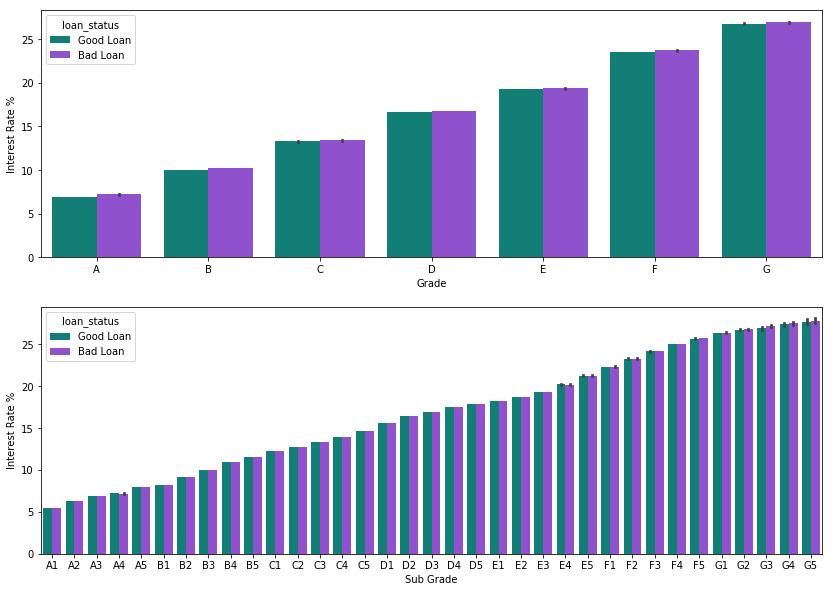

In [16]:
colors = ColorList([11,1])
plotLoanStat2(df,colors)

* Interest rates show a good correlation with loan grade. More interest applied as grade goes down from A to G
* In some cases, loan status marked as 'bad' show slightly higher inerest rate, but negligable. 
* Again, this feature may not be a good predictor of loan status!


Next, we consider variation of interest rate in time across different home ownership types by calling 'plotLoanStat3' function. (src/plotting.py)

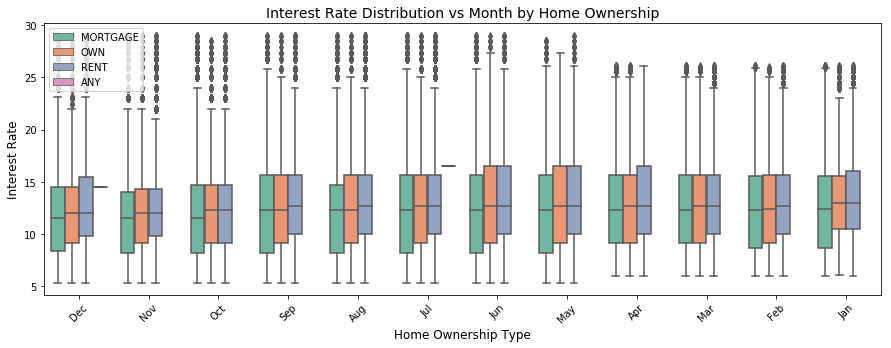

In [18]:
plotLoanStat3(df)

* Home ownership type "ANY" did not show up
* Home renters seem to pay more interest on loans compared to other cases

In [19]:
df.home_ownership.value_counts()

MORTGAGE    207683
RENT        167644
OWN          45766
ANY              2
Name: home_ownership, dtype: int64

There are only 2 cases for "ANY", that we will replace with "OWN" to reduce memory usage later for dummy encoding.

In [20]:
 df['home_ownership'] = df['home_ownership'].replace(['ANY'], 'OWN')

In [21]:
df.home_ownership.value_counts()

MORTGAGE    207683
RENT        167644
OWN          45768
Name: home_ownership, dtype: int64

### Loan Amount by Income Class

First, I make a function in order to partition income into different classes.

In [22]:
def partition_income(income):
    #np.empty(len(income))
    clas = []
    for val in range(len(income)):
        if val <= 20000:
            clas.append("lowB")
        elif (val > 20000) and (val <= 35000):
            clas.append("lowA")
        elif (val > 35000) and (val <= 50000):
            clas.append("midB")
        elif (val > 50000) and (val <= 70000):
            clas.append("midA")
        elif (val > 70000) and (val <= 100000):
            clas.append("upperB")
        elif (val > 100000) and (val <= 250000):
            clas.append("upperA")
        else:            
            clas.append("Rich")
            
    return clas
        

In [23]:
classes = partition_income(df.annual_inc.values)

Then, I add this new feature into our data frame.

In [24]:
df['inc_class'] = pd.Series( classes, index=df.index)     

In [25]:
df.inc_class.value_counts()

Rich      171094
upperA    150000
upperB     30000
lowB       20001
midA       20000
lowA       15000
midB       15000
Name: inc_class, dtype: int64

Wow! This data set seem to contain mostly rich people based on their over 250K annual income.
Let's visualize it with plotly!

In [26]:
ave_good_loan_by_class = df[df.loan_status == 'Good Loan'].groupby('inc_class',axis=0).loan_amnt.sum().astype(int)
ave_bad_loan_by_class = df[df.loan_status == 'Bad Loan'].groupby('inc_class',axis=0).loan_amnt.sum().astype(int)

#prepare data for plotly
data = [
    go.Scatterpolar(mode='lines+markers',
        r = list(ave_good_loan_by_class.values),
        theta = list(ave_good_loan_by_class.index),
        fill = 'toself',
        name = 'Good Loans',
        line = dict(color = "#63AF63"),
        marker = dict(color = "#B3FFB3",symbol = "square",size = 11),
        subplot = "polar1"),

    go.Scatterpolar(
        mode='lines+markers',
        r = list(ave_bad_loan_by_class.values),
        theta = list(ave_bad_loan_by_class.index),
        fill = 'toself', name = 'Bad Loans',
        line = dict(color = "#C31414"),
        marker = dict(color = "#FF5050",symbol = "square",size = 11),
        subplot = "polar2")
]

#define layout
layout = go.Layout(
    title="Total Good and Bad Loans by Income Class",
    showlegend = False,
    paper_bgcolor = "rgb(255, 248, 243)",
    polar1 = dict(
        domain = dict(
        x = [0,0.4],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 12
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 12
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.6,1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 12
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 12
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

**Loading static Image**

![title](./newplot3.png)

* Looks like most of the net loan money is consumed by 'Rich' and 'UpperA' class, not surprisingly amout given to other classes is marginal.
* Total loan amout given to upperA and rich class approximates 2 billion for good loans, while it is close to 500 million for bad loans. 

In [27]:
ave_good_loan_by_grade = df[df.loan_status == 'Good Loan'].groupby('grade',axis=0).cred_age.max().astype(int)
ave_bad_loan_by_grade = df[df.loan_status == 'Bad Loan'].groupby('grade',axis=0).cred_age.max().astype(int)

#prepare data for plotly
data = [
    go.Scatterpolar(mode='lines+markers',
        r = list(ave_good_loan_by_grade.values),
        theta = list(ave_good_loan_by_grade.index),
        fill = 'toself',
        name = 'Good Loans',
        line = dict(color = "#63AF63"),
        marker = dict(color = "#B3FFB3",symbol = "square",size = 11),
        subplot = "polar1"),

    go.Scatterpolar(
        mode='lines+markers',
        r = list(ave_bad_loan_by_grade.values),
        theta = list(ave_bad_loan_by_grade.index),
        fill = 'toself', name = 'Bad Loans',
        line = dict(color = "#C31414"),
        marker = dict(color = "#FF5050",symbol = "square",size = 11),
        subplot = "polar2")
]

#define layout
layout = go.Layout(
    title="Max Credit Age for Good and Bad Loans by Grade",
    showlegend = False,
    paper_bgcolor = "rgb(255, 248, 243)",
    polar1 = dict(
        domain = dict(
        x = [0,0.4],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 12
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 12
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.6,1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 12
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 12
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

**Loading static Image**

![title](./newplot2.png)

This finalizes or data analysis. Now, we shift the attention to Machine Learning.

## Machine Learning

Here using cleaned data we apply predictive modelling to identify if customer loan status is going to be
good or bad. First we apply min max normalization to numeric features. Then, to avoid issues due to data imbalance
we increase population of under represented class by simply replicating it. Then, we performe one-hot-encoding on all categorical features. Finally, we split entire data set into 70% training and 30% testing sub sets and data is ready for ML.

### Feature Normalization

In [18]:
#drop issue_month
df.drop(columns="issue_month",inplace = True)

In [19]:
#split numeric from categorical features
df_cat = df[['term','grade','sub_grade','home_ownership',
             'verification_status', 'loan_status','purpose', 'inc_class']]

df_num = df[['loan_amnt', 'int_rate', 'emp_length','annual_inc','dti', 'open_acc',
           'revol_bal', 'revol_util', 'total_acc','cred_age']]

# min max normalize numeric features
Min_Max_Scaler = preprocessing.MinMaxScaler()
df_norm = pd.DataFrame(Min_Max_Scaler.fit_transform(df_num.values))

#retrive colnames of normed df
df_norm.columns = list(df_num.columns)

#join normed feateres with categorical features
df = pd.concat([df_cat, df_norm], axis=1)

#join normed feateres with categorical features
df = pd.concat([df_cat, df_norm], axis=1)

df.fillna(0.0,inplace=True)
df.fillna(0,inplace=True)


KeyError: "['inc_class'] not in index"

### Simple trick to avoid data imbalance

Double or triple amount of underrepresented class and shuffle. When random forest classifier is used
it performs resampling anyways. 

In [55]:
from sklearn.utils import shuffle
df_bad = df[df.loan_status == 'Bad Loan']
df = pd.concat([df,df_bad])
df = shuffle(df)
df = pd.concat([df,df_bad])
df = shuffle(df)

### Split target label from data & performe dummy encoding

In [57]:
#split target labels from data
labels = df['loan_status']#.values
data = df.drop('loan_status',axis=1)#.values

#performe one-hot-encoding on categorical features
data = pd.get_dummies(data)

In [58]:
data.shape

(577095, 81)

### Train Test Split & Apply Random Fores Classification

sdsdfvc

In [59]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=10)

In [63]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500,
                            max_depth=2,
                            random_state=10,
                            n_jobs=-1)

rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [64]:
pred_test_rf = rf.predict(x_test)

In [65]:
print(confusion_matrix(y_test,pred_test_rf))
print(classification_report(y_test,pred_test_rf))

[[ 9738 60622]
 [ 4487 98282]]
              precision    recall  f1-score   support

    Bad Loan       0.68      0.14      0.23     70360
   Good Loan       0.62      0.96      0.75    102769

   micro avg       0.62      0.62      0.62    173129
   macro avg       0.65      0.55      0.49    173129
weighted avg       0.65      0.62      0.54    173129



### Plot Feature Importance

Text(0.5, 0, 'Feature Importance')

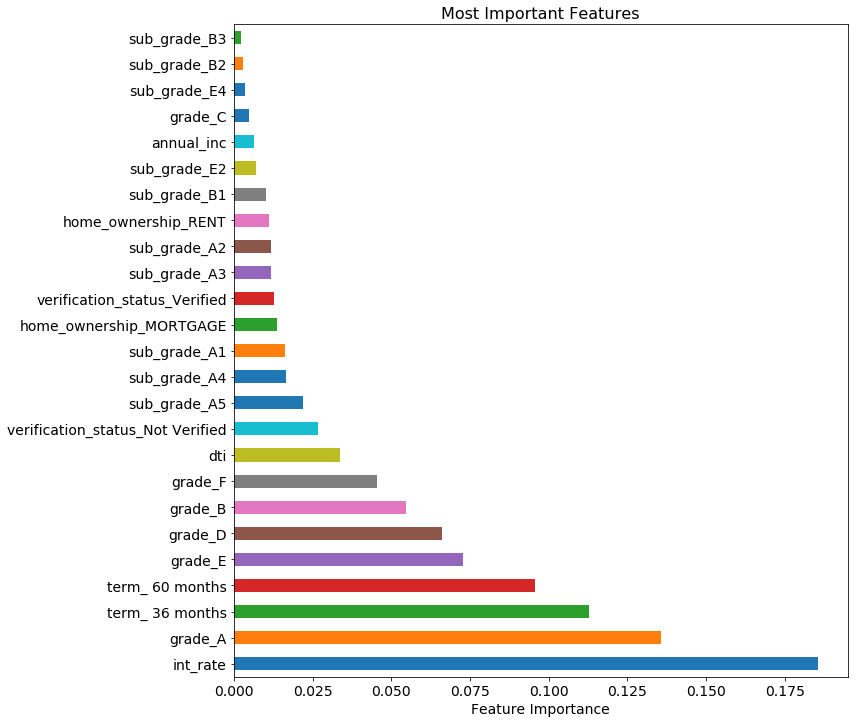

In [66]:
plt.figure(figsize = (11,12))
fs = 14
n_feat = 25
feat_importances = pd.Series(rf.feature_importances_, index = x_train.columns)
feat_importances.nlargest(n_feat).plot(kind='barh', fontsize=14)
plt.title("Most Important Features", fontsize=fs+2)
plt.xlabel("Feature Importance", fontsize=fs)

## Conclusion

